In [1]:
# %load_ext cudf.pandas
import autoroot
import autorootcwd
import random
from pathlib import Path

import json
import numpy as np
import pandas as pd
import torch
import torch.utils.checkpoint
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import h5py
from transformers import AutoTokenizer, pipeline

from matplotlib import pyplot as plt

In [2]:
random.seed(0)

In [3]:
data_root = "data/blenderproc"

In [4]:
df_train = pd.read_csv(f"{data_root}/train.csv")
df_test = pd.read_csv(f"{data_root}/test.csv")

In [5]:
df_train = df_train.sample(5, random_state=0, ignore_index=True)

In [5]:
df_train.head()

,path,uid,caption,auto_caption
0,abo_v3/C/B07L3MKRFC/1.hdf5,B07L3MKRFC,3D model of a swivel office chair with backres...,3D model of a swivel office chair with backres...
1,hf-objaverse-v3/000-062/0d4c6a10251944ebb5222e...,0d4c6a10251944ebb5222e0e503494c7,A clock lined in gold with black digits and ha...,wooden mantel clock with Roman numerals and ca...
2,hf-objaverse-v3/small_mirrors/000-058/ea84a688...,ea84a688cedb4ec0bbe992a6537c7271,A figurine of a man with a large head who is h...,Stylized figurine with exaggerated features: o...
3,hf-objaverse-v3/small_mirrors/000-045/dd4e5995...,dd4e5995803b4ba28929323f20a18b3d,A fighter jet with a single engine.,a fighter jet in flight
4,hf-objaverse-v3/000-134/3f138812227e40ebae5ea2...,3f138812227e40ebae5ea208a00ba560,A black white and brown flat jagged stone labe...,Multifaceted Flint Stone Artifact


In [6]:
row = df_train.iloc[1]
row["caption"]

'A large chunk of grey/green rock.'

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    subfolder="tokenizer",
    use_fast=False,
)

In [8]:
tokenizer(
    row["caption"],
    max_length=tokenizer.model_max_length,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
).input_ids[0]

tensor([49406,   320,  3638, 30275,   539,  5046,   270,  1901,  2172,   269,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [3]:
class HDF5Dataset(Dataset):
    """
    Dataset class to iterate over the blenderproc generated hdf5 synthetic dataset for SD 1.5
    """

    def __init__(
        self,
        data_root: str,
        df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        resolution: int = 512,
        random_mask: bool = False,
        proportion_empty_prompts: float = 0.1,
        mirror_prompt: str = "A perfect plane mirror reflection of ",
        caption_column: str = "caption",
        random_flip: bool = False,
        **kwargs,
    ):
        super().__init__()
        self.resolution = resolution
        self.tokenizer = tokenizer
        self.random_mask = random_mask
        self.data_root = Path(data_root)
        self.df = df
        self.proportion_empty_prompts = proportion_empty_prompts
        self.mirror_prompt = mirror_prompt
        self.caption_column = caption_column
        self.random_flip = random_flip
        self.kwargs = kwargs

    def __len__(self):
        return self.df.shape[0]

    def tokenize_caption(self, caption: str):
        if random.random() < self.proportion_empty_prompts:
            caption = ""
        elif isinstance(caption, str):
            caption = self.mirror_prompt + caption
        inputs = self.tokenizer(
            caption,
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return inputs.input_ids

    @staticmethod
    def get_masked_image(image, mask):
        masked_image = image.copy()
        masked_image[mask == 255] = 0
        return masked_image

    @staticmethod
    def apply_transforms_rgb(image: np.ndarray, resolution=512):
        image = np.copy(image)  # Make a copy to ensure positive strides
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        image_transforms = transforms.Compose(
            [
                transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.CenterCrop(resolution),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        image = image_transforms(image)
        return image

    @staticmethod
    def apply_transforms_mask(mask: np.ndarray, resolution=512):
        mask = np.copy(mask)  # Make a copy to ensure positive strides
        mask = torch.tensor(mask, dtype=torch.float32) / 255.0
        mask = mask.unsqueeze(0)
        mask_transforms = transforms.Compose(
            [
                transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.CenterCrop(resolution),
            ]
        )
        mask = mask_transforms(mask)
        return mask

    @staticmethod
    def apply_transforms_depth(
        depth_map: np.ndarray,
        mask: np.ndarray = None,
        normalization_method="max_scene_depth",
        max_scene_depth=5.0,
        norm_range=[-1, 1],
        delta=0.5,
        resolution=512,
        **kwargs,
    ):
        depth_map = np.copy(depth_map)  # Make a copy to ensure positive strides

        # Ensure mask is 2D by taking the first channel if it's 3D
        if mask is not None and mask.ndim == 3:
            mask = mask[:, :, 0]

        if normalization_method == "percentile":
            # Calculate the 2% and 98% percentiles
            d_2 = np.percentile(depth_map, 2)
            d_98 = np.percentile(depth_map, 98)

            # Clip the depth_map map to the range [d_2, d_98]
            clipped_depth_map = np.clip(depth_map, d_2, d_98)

            # Normalize to the specified range
            if norm_range == [0, 1]:
                normalized_depth = (clipped_depth_map - d_2) / (d_98 - d_2)
            elif norm_range == [-1, 1]:
                normalized_depth = 2.0 * (clipped_depth_map - d_2) / (d_98 - d_2) - 1.0
            else:
                raise ValueError("Unsupported normalization range. Use [0, 1] or [-1, 1].")
        elif normalization_method == "max_scene_depth":
            if mask is not None:
                # Convert mask to boolean where non-zero values are True
                bool_mask = mask > 0
                # Calculate the maximum depth value over the mask
                max_depth_over_mask = np.max(depth_map[bool_mask])
                max_scene_depth = max_depth_over_mask + delta

            # Clip the depth map to the range [0, max_scene_depth]
            clipped_depth = np.clip(depth_map, 0, max_scene_depth)

            # Normalize to the specified range
            if norm_range == [0, 1]:
                normalized_depth = clipped_depth / max_scene_depth
            elif norm_range == [-1, 1]:
                normalized_depth = 2.0 * (clipped_depth / max_scene_depth) - 1.0
            else:
                raise ValueError("Unsupported normalization range. Use [0, 1] or [-1, 1].")
        else:
            raise ValueError("Unsupported normalization method. Use 'percentile' or 'max_scene_depth'.")

        # Convert to tensor and apply transformations
        normalized_depth = torch.tensor(normalized_depth, dtype=torch.float32).unsqueeze(0)

        # Resize while keeping aspect ratio, then center crop
        resize_transform = transforms.Compose([
            transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BICUBIC),  # Resize height to maintain width of 512
            transforms.CenterCrop((resolution, resolution))  # Crop to the target resolution
        ])

        # Apply transforms
        normalized_depth = resize_transform(normalized_depth)

        return normalized_depth

    @staticmethod
    def apply_transforms_normals(
        normals_map: np.ndarray, resolution=512, mask=None, normals_conditioning_mode="ip_adapter", **kwargs
    ):
        normals_map = np.copy(normals_map)  # Make a copy to ensure positive strides
        if normals_conditioning_mode == "ip_adapter":
            # Convert mask to boolean where non-zero values are True
            bool_mask = mask > 0
            # Calculate the mean normals vector over the mask region and normalise
            mean_normals_over_mask = np.mean(normals_map[bool_mask], axis=0)  # (3,)
            # Normalize the mean normals vector
            normalized_mean_normals = mean_normals_over_mask / np.linalg.norm(mean_normals_over_mask)
            return torch.tensor(normalized_mean_normals, dtype=torch.float32).unsqueeze(0) # (1, 3)

        else:
            normals_map = torch.tensor(normals_map, dtype=torch.float32).permute(2, 0, 1)
            normals_transforms = transforms.Compose(
                [
                    transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BICUBIC),
                    transforms.CenterCrop(resolution),
                    transforms.Normalize([0.5], [0.5]),
                ]
            )
            normals_map = normals_transforms(normals_map)
            return normals_map

    @staticmethod
    def decode_cam_states(cam_states):
        """return cam2world, cam_K matrices from cam_states both as lists"""
        array = np.array(cam_states)
        json_str = array.tobytes().decode("utf-8")
        data = json.loads(json_str)
        cam2world = data["cam2world"]
        cam_K = data["cam_K"]
        return cam2world, cam_K

    @staticmethod
    def extract_data_from_hdf5(hdf5_data, random_flip=False):
        data = {
            "image": np.array(hdf5_data["colors"], dtype=np.uint8),
            "mask": (np.array(hdf5_data["category_id_segmaps"], dtype=np.uint8) == 1).astype(np.uint8) * 255,
            "object_mask": (np.array(hdf5_data["category_id_segmaps"], dtype=np.uint8) == 2).astype(np.uint8) * 255,
            "masked_image": None,  # Placeholder for masked_image
            "depth": np.array(hdf5_data["depth"]),
            "normals": np.array(hdf5_data["normals"]),
            "cam_states": np.array(hdf5_data["cam_states"]),
        }

        data["masked_image"] = HDF5Dataset.get_masked_image(data["image"], data["mask"])

        if random_flip:
            print("Horizontal flip applied")
            # TODO: add appropriate flip for cam_states if used
            for key in ["image", "mask", "object_mask", "masked_image", "depth", "normals"]:
                data[key] = np.fliplr(data[key])

        return data

    def __getitem__(self, index):
        example = {}
        row = self.df.iloc[index]
        caption = str(row[self.caption_column])
        hdf5_path = self.data_root / str(row["path"])
        hdf5_data = h5py.File(hdf5_path, "r")

        # generate common random flip for all images
        flip_horizontal = self.random_flip and random.random() < 0.5
        data = self.extract_data_from_hdf5(hdf5_data, random_flip=flip_horizontal)

        image = self.apply_transforms_rgb(data["image"], resolution=self.resolution)
        mask = self.apply_transforms_mask(data["mask"], resolution=self.resolution)
        masked_image = self.apply_transforms_rgb(data["masked_image"], resolution=self.resolution)

        example["input_ids"] = self.tokenize_caption(caption)[0]
        example["pixel_values"] = image
        example["conditioning_pixel_values"] = masked_image
        example["masks"] = mask

        if self.kwargs.get("depth", False):
            depth = self.apply_transforms_depth(
                data["depth"], mask=data["mask"], resolution=self.resolution, **self.kwargs
            )
            example["depths"] = depth

        if self.kwargs.get("normals_conditioning_mode", False):
            normals = self.apply_transforms_normals(
                data["normals"], resolution=self.resolution, mask=data["mask"], **self.kwargs
            )
            example["normals"] = normals

        if self.kwargs.get("cam_states", False):
            # TODO: add transforms if used in training
            cam2world, cam_K = self.decode_cam_states(data["cam_states"])
            example["cam2world"] = cam2world
            example["cam_K"] = cam_K

        return example


class MSDDataset(HDF5Dataset):
    """
    Dataset class to iterate over the MSD dataset for SD 1.5
    """

    def __init__(
        self,
        data_root: str,
        df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        mirror_prompt: str = "",  # default caption already contains "mirror"
        caption_column: str = "auto_caption",
        path_column: str = "path",
        **kwargs,
    ):
        super().__init__(
            data_root, df, tokenizer, mirror_prompt=mirror_prompt, caption_column=caption_column, **kwargs
        )
        self.path_column = path_column
        self.images_dir = self.data_root / "images"
        self.masks_dir = self.data_root / "masks"
        self.depth_dir = self.data_root / "depth"

    def __getitem__(self, index):
        example = {}
        row = self.df.iloc[index]
        caption = str(row[self.caption_column])
        image_path = str(row[self.path_column])

        image = np.array(Image.open(str(self.images_dir / image_path)))
        orig_mask = np.array(Image.open(str(self.masks_dir / image_path)))
        masked_image = self.get_masked_image(image, orig_mask)

        image = self.apply_transforms_rgb(image, resolution=self.resolution)
        mask = self.apply_transforms_mask(orig_mask, resolution=self.resolution)
        masked_image = self.apply_transforms_rgb(masked_image, resolution=self.resolution)

        example["input_ids"] = self.tokenize_caption(caption)[0]
        example["pixel_values"] = image
        example["conditioning_pixel_values"] = masked_image
        example["masks"] = mask

        if self.kwargs.get("depth", False):
            depth = np.load(self.depth_dir / image_path.replace("png", "npz"))["depth"]
            depth = self.apply_transforms_depth(depth, mask=orig_mask, resolution=self.resolution, **self.kwargs)
            example["depths"] = depth

        return example

In [30]:
dataset = HDF5Dataset(data_root, df_train, tokenizer, random_flip=True, depth=True, normals_conditioning_mode="ip_adapter", cam_states=True)

In [40]:
example = dataset[0]

Horizontal flip applied


In [13]:
# plot unnormalized numpy image and depth map from torch tensors
def plot_image(image, masks, depth=None, normals=None):
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))

    # Plot image
    numpy_image = image.permute(1, 2, 0).numpy()
    unnormalized_image = (numpy_image / 2 + 0.5)
    axes[0].imshow(unnormalized_image)
    axes[0].set_title('Image')

    # Plot masks
    numpy_masks = masks.permute(1, 2, 0).numpy()
    axes[1].imshow(numpy_masks)
    axes[1].set_title('Masks')

    if depth is not None:
        # Plot depth map
        numpy_depth = depth.squeeze().numpy()
        axes[2].imshow(numpy_depth, cmap='magma')
        axes[2].set_title('Depth map')
        # show value range for depth map using bar
        plt.colorbar(axes[2].imshow(numpy_depth, cmap='magma'), ax=axes[2])

    if normals is not None:
        # plot normal map
        numpy_normals = normals.permute(1, 2, 0).numpy()
        unnormalized_normals = (numpy_normals / 2 + 0.5)
        axes[3].imshow(unnormalized_normals)
        axes[3].set_title('Normals')

    plt.show()

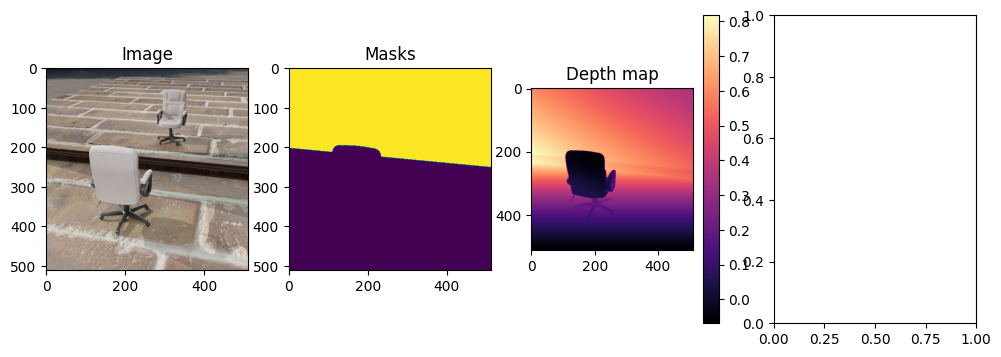

In [42]:
plot_image(example["pixel_values"], example["masks"], example["depths"])

In [16]:
cam2world = example["cam2world"]
print(f'cam2world matrix: {cam2world}, type: {type(cam2world)}')

cam_K = example["cam_K"]
print(f'cam_K matrix: {cam_K}, type: {type(cam_K)}')

cam2world matrix: [[-0.8289365172386169, 0.14476685225963593, -0.5402839183807373, -2.3062734603881836], [-0.5593425631523132, -0.21454210579395294, 0.8006919026374817, 2.848926067352295], [-1.0974880559899702e-08, 0.9659266471862793, 0.25881606340408325, 1.017473578453064], [0.0, 0.0, 0.0, 1.0]], type: <class 'list'>
cam_K matrix: [[711.1112738715278, 0.0, 255.5], [0.0, 711.1112738715278, 255.5], [0.0, 0.0, 1.0]], type: <class 'list'>


### creating a dictionary with cam matrix as key

In [17]:
# Convert the list of lists to a tuple of tuples
cam2world_tuple = tuple(tuple(row) for row in cam2world)

# Create a key-value map
cam2world_map = {cam2world_tuple: "bbox_stuff"}

# Example of fetching the value using the cam2world matrix
fetched_value = cam2world_map[cam2world_tuple]

print(fetched_value)  # Output: bbox_stuff

bbox_stuff


### Test positional encoding

In [11]:

class FreqEncoder(torch.nn.Module):
    """Frequency Encoder
    Taken from: https://github.com/ashawkey/torch-ngp/blob/main/encoding.py
    """
    def __init__(
        self,
        input_dim,
        max_freq_log2,
        N_freqs,
        log_sampling=True,
        include_input=True,
        periodic_fns=(torch.sin, torch.cos),
    ):
        super().__init__()

        self.input_dim = input_dim
        self.include_input = include_input
        self.periodic_fns = periodic_fns

        self.output_dim = 0
        if self.include_input:
            self.output_dim += self.input_dim

        self.output_dim += self.input_dim * N_freqs * len(self.periodic_fns)

        if log_sampling:
            self.freq_bands = 2.0 ** torch.linspace(0.0, max_freq_log2, N_freqs)
        else:
            self.freq_bands = torch.linspace(2.0**0.0, 2.0**max_freq_log2, N_freqs)

        self.freq_bands = self.freq_bands.numpy().tolist()

    def forward(self, input, **kwargs):
        out = []
        if self.include_input:
            out.append(input)

        for i in range(len(self.freq_bands)):
            freq = self.freq_bands[i]
            for p_fn in self.periodic_fns:
                out.append(p_fn(input * freq))

        out = torch.cat(out, dim=-1)

        return out


class NormalProjModel(torch.nn.Module):
    """Normal Projection Model"""

    def __init__(self, cross_attention_dim=1024, normals_embeddings_dim=255):
        super().__init__()
        self.cross_attention_dim = cross_attention_dim
        self.normals_embeddings_dim = normals_embeddings_dim

        self.proj = torch.nn.Sequential(
            torch.nn.Linear(normals_embeddings_dim, cross_attention_dim),
            torch.nn.GELU(),
        )

    def forward(self, normal_embeds):
        normals_extra_context_tokens = self.proj(normal_embeds)
        return normals_extra_context_tokens

In [16]:
# Initialize the FreqEncoder
encoder = FreqEncoder(
    input_dim=3,
    max_freq_log2=8,
    N_freqs=85,
    log_sampling=True,
    include_input=False,
    periodic_fns=(torch.sin, torch.cos)
)
# Initialize the NormalProjModel
proj_model = NormalProjModel(cross_attention_dim=1024, normals_embeddings_dim=255)

In [22]:
pos_encoded_normals = encoder(example["normals"].unsqueeze(0))

In [23]:
pos_encoded_normals.shape

torch.Size([1, 510])

In [24]:
proj_model = NormalProjModel(cross_attention_dim=1024, normals_embeddings_dim=510)

In [25]:
projected_output = proj_model(pos_encoded_normals)

In [26]:
projected_output.shape

torch.Size([1, 1024])

## MSD Dataset

In [4]:
data_root = "data/MSD"

#### Create splits

In [5]:
captions_df = pd.read_csv(f"{data_root}/captions.csv", usecols=["Captions", "images"])

In [27]:
# rename "Captions" column to "auto_caption" and "images" to "path"
captions_df = captions_df.rename(columns={"Captions": "auto_caption", "images": "path"})

In [28]:
# for all rows of the dataframe, replace ".jpg" of path column with ".png".
# Also create another column called "uid" which separates path with "_" (taking first part)
captions_df["path"] = captions_df["path"].str.replace(".jpg", ".png")
captions_df["uid"] = captions_df["path"].str.split("_").str[0]

In [29]:
captions_df.head()

,path,auto_caption,uid
0,324_512x640.png,"In the image, there are two red stuffed animal...",324
1,2252_512x640.png,"In the image, a yellow emoji figurine with sun...",2252
2,555_512x640.png,"In the image, a mirror is placed on a desk nex...",555
3,209_512x640.png,"In the image, there is a tiled floor with a dr...",209
4,2571_512x640.png,"In the image, there is a mirror placed on a de...",2571


In [30]:
test_set_size = 300
train_set_size = len(captions_df) - test_set_size

# shuffle the dataframe
captions_df = captions_df.sample(frac=1, random_state=0).reset_index(drop=True)
df_train = captions_df.iloc[:train_set_size]
df_test = captions_df.iloc[train_set_size:]

In [31]:
print(len(df_train), len(df_test))

3718 300


In [32]:
# save train and test dfs
df_train.to_csv(f"{data_root}/train.csv", index=False)
df_test.to_csv(f"{data_root}/test.csv", index=False)

#### testing

In [7]:
df_train = pd.read_csv(f"{data_root}/train.csv")
df_test = pd.read_csv(f"{data_root}/test.csv")

In [7]:
long_caption = df_train.iloc[0]["auto_caption"]
print(long_caption)
print(len(long_caption))

The dynamics of the mirror and its reflections involve the use of colorful building blocks, which are placed on a table in front of the mirror. The mirror creates an optical illusion by reflecting the blocks in such a way that they appear to form the letter "T" when viewed from a certain angle. This optical illusion is created by the way the light bounces off the surface of the mirror and interacts with the colors of the building blocks. The result is a visually interesting and engaging display that challenges the viewer's perception of reality.
551


In [8]:
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-6-6")

In [9]:
summary = summarizer(long_caption, max_length=50, min_length=10, do_sample=False)

In [10]:
print(summary[0]['summary_text'])

 The optical illusion is created by the way the light bounces off the surface of the mirror and interacts with the colors of the building blocks . The result is a visually interesting and engaging display that challenges the viewer's perception of reality .


In [10]:
dataset = MSDDataset(data_root, df_train, tokenizer, depth=True)

In [11]:
example = dataset[3]

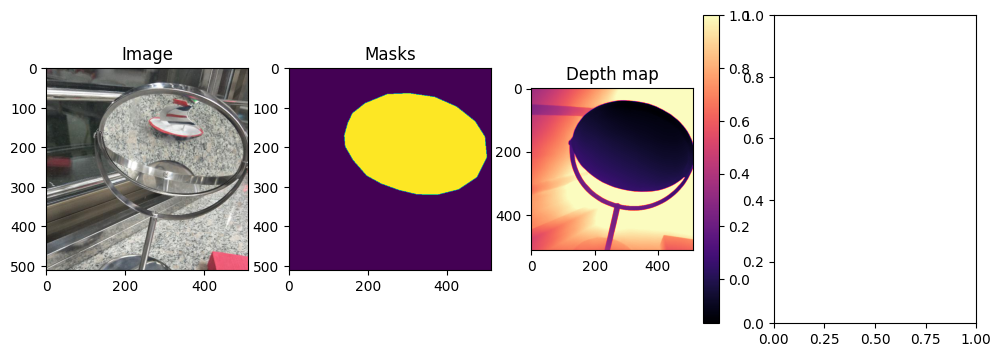

In [14]:
plot_image(example["pixel_values"], example["masks"], example["depths"])

In [15]:
example["pixel_values"].shape, example["masks"].shape, example["depths"].shape

(torch.Size([3, 512, 512]),
 torch.Size([1, 512, 512]),
 torch.Size([1, 512, 512]))